### Figure notebook for plotting MERFISH scVI and scANVI integration

In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata as ad
import scanpy as sc
from matplotlib.lines import Line2D
import string

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
def set_plotting_style_huge():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=24)
    plt.rc('axes', titlesize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=20)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=4)
    plt.rc('ytick.major', pad=4)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
        
    
# Function to preprocess raw AnnData object

def preprocess_ad(ad, min_counts):
    ad.layers['counts'] = ad.X.copy()
    sc.pp.filter_cells(ad, min_counts=min_counts)
    sc.pp.normalize_total(ad, target_sum=1e4) # Normalize data
    sc.pp.log1p(ad) # Logarithmize the data
    sc.pp.scale(ad) # Scale each gene to unit variance

In [2]:
# Load data
fileDir = '../../../data/SingleCellData/annotated/'

liver_concat = ad.read_h5ad(fileDir + 'scVI_liver_object.h5ad')
kidney_concat = ad.read_h5ad(fileDir + 'scVI_kidney_object.h5ad')

# Remap cell type labels to coarse groups
liver_relabel_map = {'B cell': 'immune cell',
                    'NK cell': 'immune cell',
                    'periportal endothelial cell': 'periportal endothelial cell',
                    'pericentral endothelial cell': 'pericentral endothelial cell',
                    'other endothelial cell': 'other endothelial cell',
                    'myeloid leukocyte': 'immune cell',
                    'plasmacytoid dendritic cell': 'immune cell',
                    'Kupffer cell': 'Kupffer cell',
                    'hepatic stellate cell': 'hepatic stellate cell',
                    'other hepatocyte': 'other hepatocyte',
                    'periportal hepatocyte': 'periportal hepatocyte',
                    'pericentral hepatocyte': 'pericentral hepatocyte'}
kidney_relabel_map = {'macrophage': 'immune cell',
                     'lymphocyte': 'immune cell',
                     'glomerular capillary endothelial cell': 'endothelial cell',
                     'kidney blood vessel cell': 'endothelial cell',
                     'plasma cell': 'immune cell',
                     'epithelial cell of proximal tubule': 'epithelial cell of proximal tubule',
                     'kidney loop of Henle epithelial cell': 'kidney loop of Henle epithelial cell',
                     'kidney distal convoluted tubule epithelial cell': 'kidney distal convoluted tubule epithelial cell',
                     'kidney collecting duct epithelial cell': 'kidney collecting duct epithelial cell',
                     'pericyte': 'pericyte',
                     'podocyte': 'podocyte',
                     'fibroblast': 'fibroblast'}

liver_concat.obs['predicted_cell_type'] = liver_concat.obs['predicted_cell_type'].map(liver_relabel_map)
kidney_concat.obs['predicted_cell_type'] = kidney_concat.obs['predicted_cell_type'].map(kidney_relabel_map)

# Create abbreviated cell type labels
liver_abbrev_map = {'immune cell': 'IC',
                   'other endothelial cell': 'o-EC',
                   'Kupffer cell': 'KC',
                   'hepatic stellate cell': 'HSC',
                   'other hepatocyte': 'o-hep',
                   'periportal hepatocyte': 'PP-hep',
                   'pericentral hepatocyte': 'PC-hep',
                   'periportal endothelial cell': 'PP-EC',
                   'pericentral endothelial cell': 'PC-EC'}
kidney_abbrev_map = {'epithelial cell of proximal tubule':'EC-PT',
                    'immune cell': 'IC',
                    'pericyte':'per',
                    'kidney loop of Henle epithelial cell':'KLH-EC',
                    'kidney collecting duct epithelial cell':'KCD-EC',
                    'kidney distal convoluted tubule epithelial cell':'KDCT-EC',
                    'endothelial cell': 'EC',
                    'podocyte':'pod',
                    'fibroblast':'fib'}

liver_concat.obs['predicted_cell_type_abv'] = liver_concat.obs['predicted_cell_type'].map(liver_abbrev_map)
kidney_concat.obs['predicted_cell_type_abv'] = kidney_concat.obs['predicted_cell_type'].map(kidney_abbrev_map)

print('Results loaded.')

Results loaded.


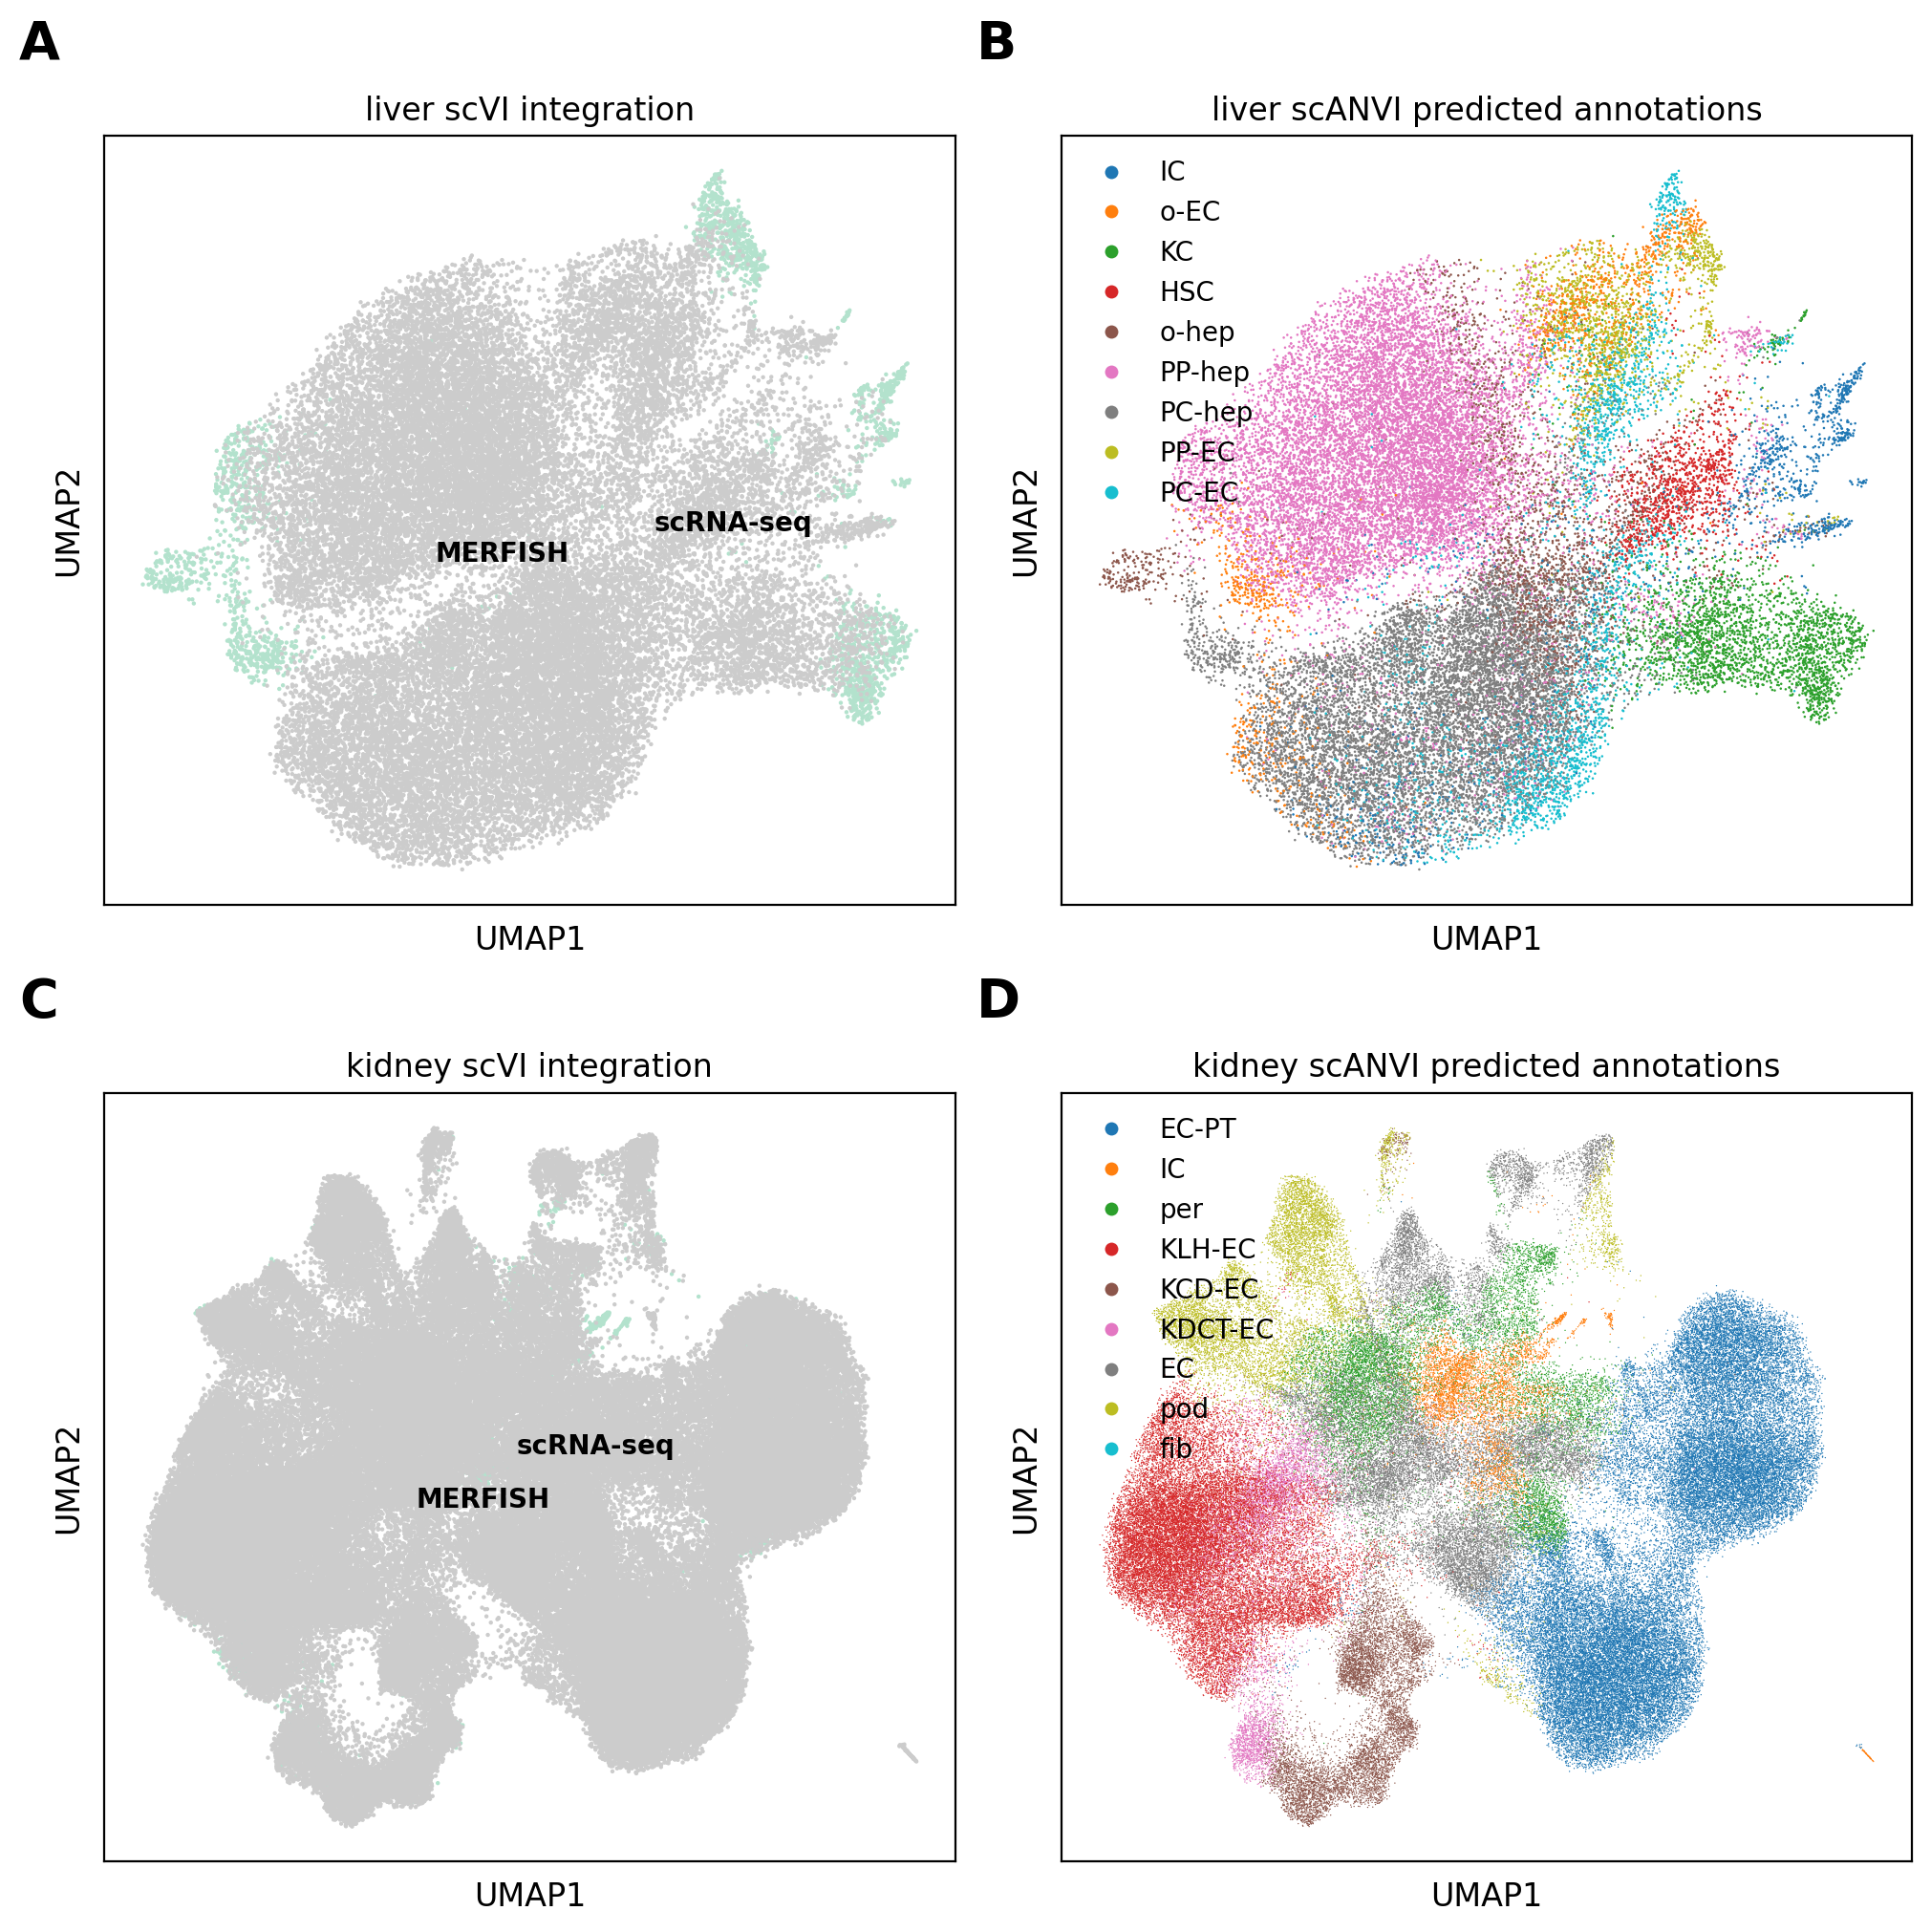

In [4]:
# Plot the liver only (new layout)
sc.set_figure_params(vector_friendly=True, dpi=300, dpi_save=2000)
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
set_plotting_style()

fig, axes = plt.subplots(2,2,figsize=(10,10), constrained_layout=True) # Create figure

# Use the same colormap for the cell types between methods
colormap_liver = {list(liver_abbrev_map.values())[x]:
                 mpl.cm.get_cmap('tab10',len(list(liver_abbrev_map.values())))(x) for x in
                 range(len(list(liver_abbrev_map.values())))}
colormap_kidney = {list(kidney_abbrev_map.values())[x]:
                 mpl.cm.get_cmap('tab10',len(list(kidney_abbrev_map.values())))(x) for x in
                 range(len(list(kidney_abbrev_map.values())))}

# Panel A: liver scVI
ax = axes[0,0]
sc.pl.umap(liver_concat, color='tech', ax=ax, show=False, legend_loc='on data',
           palette='Pastel2', frameon=True, size=10)
ax.set_title('liver scVI integration')

# Panel B: liver scANVI
ax = axes[0,1]
liver_legend = [Line2D([0], [0], marker='o', color='w', label=list(colormap_liver.keys())[x],
                        markerfacecolor=list(colormap_liver.values())[x], markersize=5)
                for x in range(len(colormap_liver))]
sc.pl.umap(liver_concat, color='predicted_cell_type_abv', ax=ax, show=False,
             palette=colormap_liver)
ax.legend(handles=liver_legend, loc='upper left', frameon=False)
ax.set_title('liver scANVI predicted annotations')

# Panel C: kidney scVI
ax = axes[1,0]
sc.pl.umap(kidney_concat, color='tech', ax=ax, show=False, legend_loc='on data',
           palette='Pastel2', frameon=True, size=10)
ax.set_title('kidney scVI integration')

# Panel D: kidney scANVI
ax = axes[1,1]
kidney_legend = [Line2D([0], [0], marker='o', color='w', label=list(colormap_kidney.keys())[x],
                        markerfacecolor=list(colormap_kidney.values())[x], markersize=5)
                for x in range(len(colormap_kidney))]
sc.pl.umap(kidney_concat, color='predicted_cell_type_abv', ax=ax, show=False,
             palette=colormap_kidney, legend_loc=None)
ax.legend(handles=kidney_legend, loc='upper left', frameon=False)
ax.set_title('kidney scANVI predicted annotations')

# Label subpanels
axes_label = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]
for n, ax in enumerate(axes_label):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')

plt.show()

In [4]:
# Export figures
fig.savefig('../../figures/SIFig_scVI_integration.svg', transparent=True)
fig.savefig('../../figures/SIFig_scVI_integration.png', transparent=True)

print('Figures saved.')

Figures saved.
